# Spiking Convolutional Neural Network on Speck

In this section you will learn about Speck, a neuromorphic system that integrates a Dynamic Vision Sensor and a Spiking Convolutional Neural Network on device. In the following sections, you will learn how to interact with the Speck chip, how to read and write events to the network, visualize them and how to load a network.

Then you will train an SNN to solve a simple task and load it on Speck. You will then be able to run the network on inference and visualize its response in real time.



## Speck device

Speck is a neuromorphic device with characteristics in hardware and Samna has developed the software that we'll see

### Hardware

- DVS input with 128x128 resolution
- 9 convolutional layers
- Limitations in each layer
- Implementation of IAF neurons
- Leak through bias and external clock

### Software

- Library Samna
- Simulator, they use sinabs
- The have the idea of the graph to stream information and communicate with the machine
- They have filters. One can develop filters themselves

## Interaction with Speck

In this section, we will see how to communicate with speck, we will visualize events and develop a network for edge detection that we'll load to speck.


### Task 0.1: Import libraries

We begin by importing the necessary libraries for our implementation, such as samna, sinabs, torch and libraries to help us fetch and vsualize our data.

In [ ]:
!pip install -q samna
!pip install -q sinabs

import samna
import torch
import pickle
import tqdm
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from IPython.display import HTML
from torch.utils.data import DataLoader, Dataset, random_split
from urllib.request import urlretrieve
import sinabs.layers as sl
from torch import nn
from sinabs.activation.surrogate_gradient_fn import PeriodicExponential
from operator import iconcat
from functools import reduce
import pickle

### Task 0.2: Fetch data

Now we will fetch the data files that we will use for our next experiment.

You will notice that the format of the spikes is not the  Address Event Representation that has been previously discussed. What is this new format?

In [25]:
data_file, _ = urlretrieve("https://github.com/ncskth/phd-course/raw/main/book/module4/edge_detect")
with open(data_file, 'rb') as f:
  data = pickle.load(f)

print(data[0])

[speck2f::event::Spike(layer=13, feature=0, y=32, x=78, timestamp=6318139)]


### Task 1: Visualize DVS output

In this task you are asked to visualize your input data. Before working with the data, we should convert them in a friendly format (a tensor).

Note that we bin events every 10000μs (10ms). You will need this information when constructing the video from events.

In [ ]:
def events_to_channels(events, time_interval = 1000):
    frames = []
    index = 0
    current_frame = torch.zeros(2, 128, 128)
    for (t, y, x, p) in tqdm.tqdm(events.int()):
        if t // time_interval > index:
            frames.append(current_frame.clone())
            current_frame.fill_(0)
            index += 1
        current_frame[p, x, y] = +1
    return torch.stack(frames)


def Speck_spikes_to_events(sp_events):

  sp_events = reduce(iconcat, sp_events, [])
  events = torch.zeros((len(sp_events), 4))
  start = sp_events[0].timestamp

  for i, e in tqdm.tqdm(enumerate(sp_events), total=len(sp_events)):
    events[i][0] = e.timestamp - start
    events[i][1] = e.x
    events[i][2] = e.y
    events[i][3] = e.feature
  return events



# Convert Speck spikes to tensor

events = Speck_spikes_to_events(data)
events = events_to_channels(events, 10000)

Use the functions that are provided in the cell bellow to create a video of your input data.

In [ ]:
def animate_frames(frames, figure=None, interval: int = 20, **kwargs):
    if figure is None:
        figure, _ = plt.subplots(**kwargs)
    ax = figure.gca()

    image = ax.imshow(frames[0])  # .T)
    ax.set_axis_off()

    def animate(index):
        image.set_data(frames[index])  # .T)
        return image

    anim = FuncAnimation(figure, animate, frames=len(frames), interval=interval)
    video = anim.to_html5_video()
    html = HTML(video)
    display(html)
    plt.tight_layout()
    plt.close()


def events_to_frames(frames, polarity: bool = True):
    if len(frames.shape) == 3:
        frames = frames.unsqueeze(-1).repeat(1, 1, 1, 3)
    else:
        if not polarity:
            frames = frames.abs().sum(-1)
        elif polarity:
            frames = torch.concat([frames, torch.zeros(frames.shape[0], 1, *frames.shape[2:], device=frames.device)], dim=1).movedim(1, -1)
    frames = ((frames / frames.max()) * 255).int().clip(0, 255)
    return frames

# Visualize your input data

# ...

### Task 2: Create edge detector in sinabs

For this task you will have to create an edge detector. You will need to create a Spiking Convolutional Neural Network that detects vertical and horizontal edges.

Note that your neuros should be Integrate and Fire as Speck does not implement leak directly!

#### Task 2.1: Convolutional layer

In the following cell, you have an example of an edge detector. Use this as your kernel to develop your network. What should the shape of the convolutional layer's weights be?

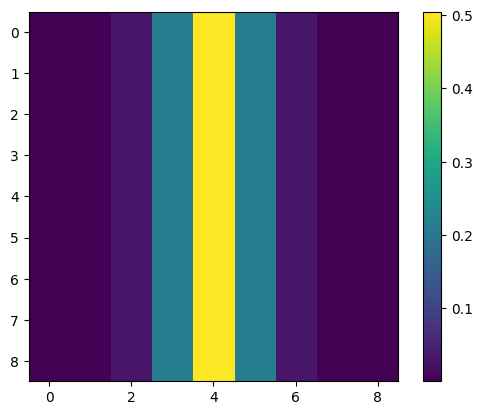

In [64]:
kernel_size = 9
gaussian = torch.sigmoid(torch.linspace(-10, 10, kernel_size + 1))
kernel = (gaussian.diff()-0.14).repeat(kernel_size, 1)
plt.imshow(kernel)
plt.colorbar()


#### Task 2.2: Network implementation

For this task, you will have to implement and run your network using the sinabs library. This library will allow you to transfer your network to the Speck chip. You can use `sl.IAFSqueeze()` to implement the integration of spikes.

Note: The biases should be set to None!

In [95]:
snn_bptt = nn.Sequential(
    # [2, 128, 128] -> [2, 64, 64]
    # Fill in your convolutional layer here. Note: Bias should be None!
    sl.IAFSqueeze(batch_size=1, min_v_mem=-1.0),
    )

out = snn_bptt(events)

# Every positive output of the network is a spike produced by the network. We threshold with out > 0 to normalize the output to 0 or 1 (spike or no spike) at each frame
print(torch.sum(out - out.int()))
out = (out > 0).float()

tensor(0.)


In [ ]:
animate_frames(events_to_frames(out[:400], polarity=True))

#### Task 2.2: Visualize the output

Using the provided function above, visualize the output. What do you observe? How can you suppress the noise?

Speck neurons can implement [leak](https://synsense.gitlab.io/sinabs-dynapcnn/getting_started/notebooks/leak_neuron.html) through their bias.


In [ ]:
# Visualize the output

# ...

### Task 3: Train a spiking neural network

In this task you will develop a Spiking Convolutional Neural Network to solve a simple classification problem. You are encouraged to use Sinabs, to be able to load your network to the Speck chip.

The data consist of Speck recordings where objects of each class have been recorded using the Dynamic Vision Sensor of speck2f.

In this task, the data consist of 5 classes (apple, car, flower, dog, ship). To avoid time consumption, the data are already given in tensor format. Each dataset is split in two files `_tensor_1.pt` and `_tensor_2.pt`

Due to time limitations, you are advised to start working with 2 classes (for example apple and car) and a subset of the data (N number of events).

In [97]:
#### Task 3.0: Load the data

In [ ]:
apple_file_1, _ = urlretrieve("https://github.com/ncskth/phd-course/raw/main/book/module4/apple_tensor_1.pt")
apple_events = torch.load(apple_file_1)
apple_file_2, _ = urlretrieve("https://github.com/ncskth/phd-course/raw/main/book/module4/apple_tensor_2.pt")
apple_events = torch.load(apple_file_2)


car_file_1, _ = urlretrieve("https://github.com/ncskth/phd-course/raw/main/book/module4/car_tensor_1.pt")
car_events = torch.load(car_file_1)
car_file_2, _ = urlretrieve("https://github.com/ncskth/phd-course/raw/main/book/module4/car_tensor_2.pt")
car_events = torch.load(car_file_2)

apple = events_to_channels(apple_events)
car = events_to_channels(car_events)

#### Task 3.1: Visualize the data

Using the functions provided in previous tasks, visualize your input data. You can start by visualizing the first 10 seconds of the data.

In [ ]:
# Visualize your data

# ...

#### Task 3.2: Create the dataloader

To be able to load the data to train the network, you should create a dataloader from the given data. In the cell bellow, you have to fill in the missing lines to create your dataloader

You might find useful the [`random_split`](https://pytorch.org/docs/stable/data.html) function and the [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) module.

In [ ]:
class SpeckDataset(Dataset):
    def __init__(self, frames, targets, transform=None, target_transform=None):
        self.targets = targets
        self.frames = frames
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        frames = self.frames[idx]
        label = self.targets[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return frames, label


time_bin = 10000
train_perc = 0.8
batch_size = 10

c = car[:time_bin*(car.shape[0]//time_bin)].reshape((car.shape[0]//time_bin, time_bin, *car.shape[1:]))
a = apple[:time_bin*(apple.shape[0]//time_bin)].reshape((apple.shape[0]//time_bin, time_bin, *apple.shape[1:]))

c_t = torch.zeros(c.shape[0])
a_t = torch.zeros(a.shape[0])+1

data = torch.cat((c, a), dim=0)
targets = torch.cat((c_t, a_t), dim=0)


# Create the dataset using the SpeckDataset module
# dataset = ...

# Split the data to trainset and testset
# trainset, testset =

# Define the trainloader and testloader DataLoaders
# ...

#### Task 3.3: Develop your network

Use the torch sequential and the `sl.IAFSqueeze()` modules to develop your network. Be aware os the [speck's architecture](https://synsense-sys-int.gitlab.io/samna/models/speckSeries/summary.html) regarding the size of the network.

In [ ]:
snn_bptt = nn.Sequential(
    # ...
)

#### Task 3.4: Train your network

You should implement your training and testing loop. Fill in the train and test function and evaluate the result.

You are advised to use Google Colab's GPU resources to accelerate the training.

In [100]:
# define the functions' signatures (parameters and return)
def train():
  for data, label in tqdm.tqdm(trainloader):
    # reshape the input from [Batch, Time, Channel, Height, Width] into [Batch*Time, Channel, Height, Width]
    data = data.reshape(-1, 2, 128, 128)

    # fill in the rest of the function




def test():
  with torch.no_grad():
    for data, label in tqdm.tqdm(testloader):
      # reshape the input from [Batch, Time, Channel, Height, Width] into [Batch*Time, Channel, Height, Width]
      data = data.reshape(-1, 2, 128, 128)

      # fill in the rest of the function

# Define the optimizer and the loss function
# optimizer = ...
# criterion = ...

# Train your network